In [1]:
import numpy as np
import json
from pathlib import Path
from astropy.constants import c, G, M_sun, pc
import matplotlib.pyplot as plt
import corner
from la_forge.utils import bayes_fac

In [2]:
def cg1_mass(solarmass_mass): # Convert mass from solar mass to seconds
    return solarmass_mass * (M_sun.value) * (G.value/(c.value**3))

def log_cg1_mass(log_solarmass_mass):
    return log_solarmass_mass + np.log10(M_sun.value) + np.log10(G.value/(c.value**3))

def cg1_dist(mpc_dist): # Convert distance from Kpc to seconds
    mpc = pc * (10**6)
    return mpc_dist * mpc.value / c.value

def log_cg1_dist(log_mpc_dist):
    mpc = pc * (10**6)
    return log_mpc_dist + np.log10(mpc.value / c.value)
    
def calc_strain(solarmass_mass, freq, mpc_dist):
    mass = cg1_mass(solarmass_mass)
    dist = cg1_dist(mpc_dist)
    nom = 2 * (mass ** (5/3)) * np.pi * (freq ** (2/3))
    return nom / dist

def calc_log10_strain(log10solarmass_mass, log10freq, log10mpc_dist):
    log10mass = log_cg1_mass(log10solarmass_mass)
    log10dist = log_cg1_dist(log10mpc_dist)
    log10strain = (5/3) * log10mass + (2/3) * log10freq - log10dist + np.log10(2*np.pi)
    return log10strain

In [3]:
dataPath = Path('/home/frh7/targeted_searches_old/data/chains/ng15_v1p1/ZTF18abxxohm_det/')

separate_chains = {}

for di in dataPath.iterdir():
    chain_num = int(di.name)
    print(f'Loading chain {chain_num}')
    chain_path = di / 'chain_1.txt'
    chain = np.loadtxt(chain_path)
    print(f'\t{chain.shape[0]} samples and {chain.shape[1]} parameters')
    print(f'\tAcceptance rate: {chain[-1, -2]:.2}')
    separate_chains[di] = chain
combined_chain_noburn = np.vstack([x for x in separate_chains.values()])
print(f'combined chain has {combined_chain_noburn.shape[0]} samples with {combined_chain_noburn.shape[1]} parameters')

Loading chain 1
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 10
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 11
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 12
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 2
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 3
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 4
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 5
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 6
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 7
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 8
	100001 samples and 276 parameters
	Acceptance rate: 0.75
Loading chain 9
	100001 samples and 276 parameters
	Acceptance rate: 0.75
combined chain has 1200012 samples with 276 parameters


In [4]:
parampath = dataPath / '1' / 'model_params.json'
with open(parampath, 'r') as pf:
    params = json.load(pf) + ['lnpost', 'lnlike', 'chain_accept', 'pt_chain_accept']
print(f'Loaded {len(params)} parameters')

Loaded 276 parameters


In [5]:
target_prior_path = '/home/frh7/targeted_searches_old/priors/ZTF18abxxohm_priors.json'
with open(target_prior_path, 'r') as f:
    target_priors = json.load(f)
target_priors

{'RA': '19h30m25.294s',
 'DEC': '+64d29m23.578s',
 'log10_dist': 2.887,
 'log10_freq': -7.348469980409295}

In [6]:
burn_in = 0.25
combined_chain_burn = np.vstack([x[int(len(x)*burn_in):] for x in separate_chains.values()])
print(f'combined chain has {combined_chain_burn.shape[0]} samples after burn in with {combined_chain_burn.shape[1]} parameters')

combined chain has 900012 samples after burn in with 276 parameters


In [7]:
params[-10:]

['J2322+2057_red_noise_gamma',
 'J2322+2057_red_noise_log10_A',
 'cos_inc',
 'log10_mc',
 'phase0',
 'psi',
 'lnpost',
 'lnlike',
 'chain_accept',
 'pt_chain_accept']

Text(0, 0.5, 'log10_mc')

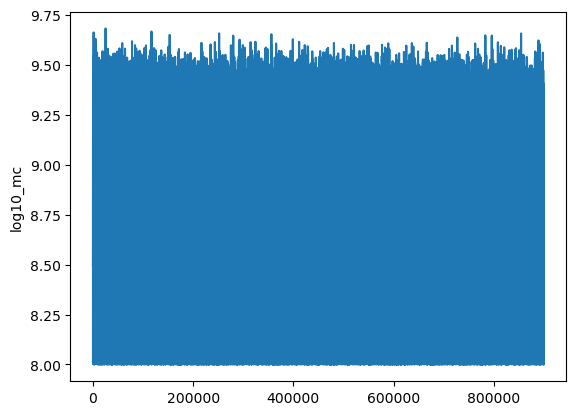

In [8]:
fig, ax = plt.subplots()
ax.plot(combined_chain_burn[:,-7])
ax.set_ylabel('log10_mc')

In [9]:
log10masses = combined_chain_burn[:,-7]
log10dists = 2.887
log10freqs = -7.348469980409295

log10_strain = calc_log10_strain(log10masses, log10freqs, log10dists)
log10_strain_min = calc_log10_strain(8, log10freqs, log10dists)
log10_strain_max = calc_log10_strain(11, log10freqs, log10dists)

Text(0, 0.5, 'log10_h')

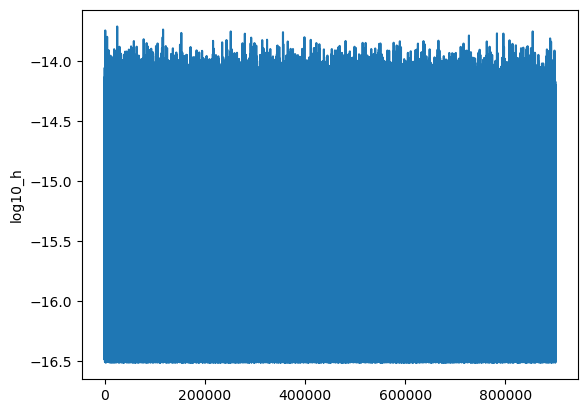

In [10]:
fig, ax = plt.subplots()
ax.plot(log10_strain)
ax.set_ylabel('log10_h')

Text(0.5, 0, 'ln_likelihood')

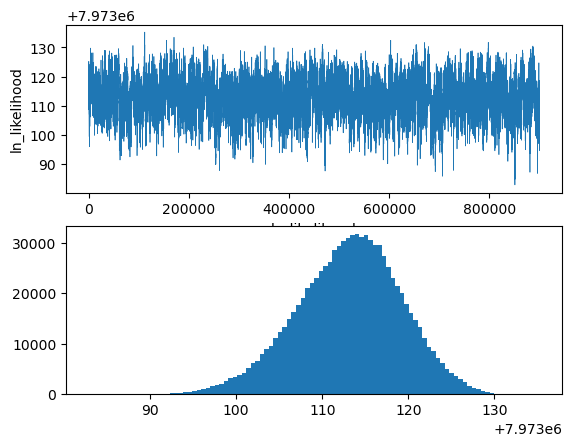

In [11]:
fig, axs = plt.subplots(2)
axs[0].plot(combined_chain_burn[:,-3], linewidth=0.5)
axs[0].set_ylabel('ln_likelihood')

axs[1].hist(combined_chain_burn[:,-3], bins=100)
axs[0].set_xlabel('ln_likelihood')

In [12]:
bf_mass, bf_mass_sigma = bayes_fac(combined_chain_burn[:,-7], logAmin=8, logAmax=11)

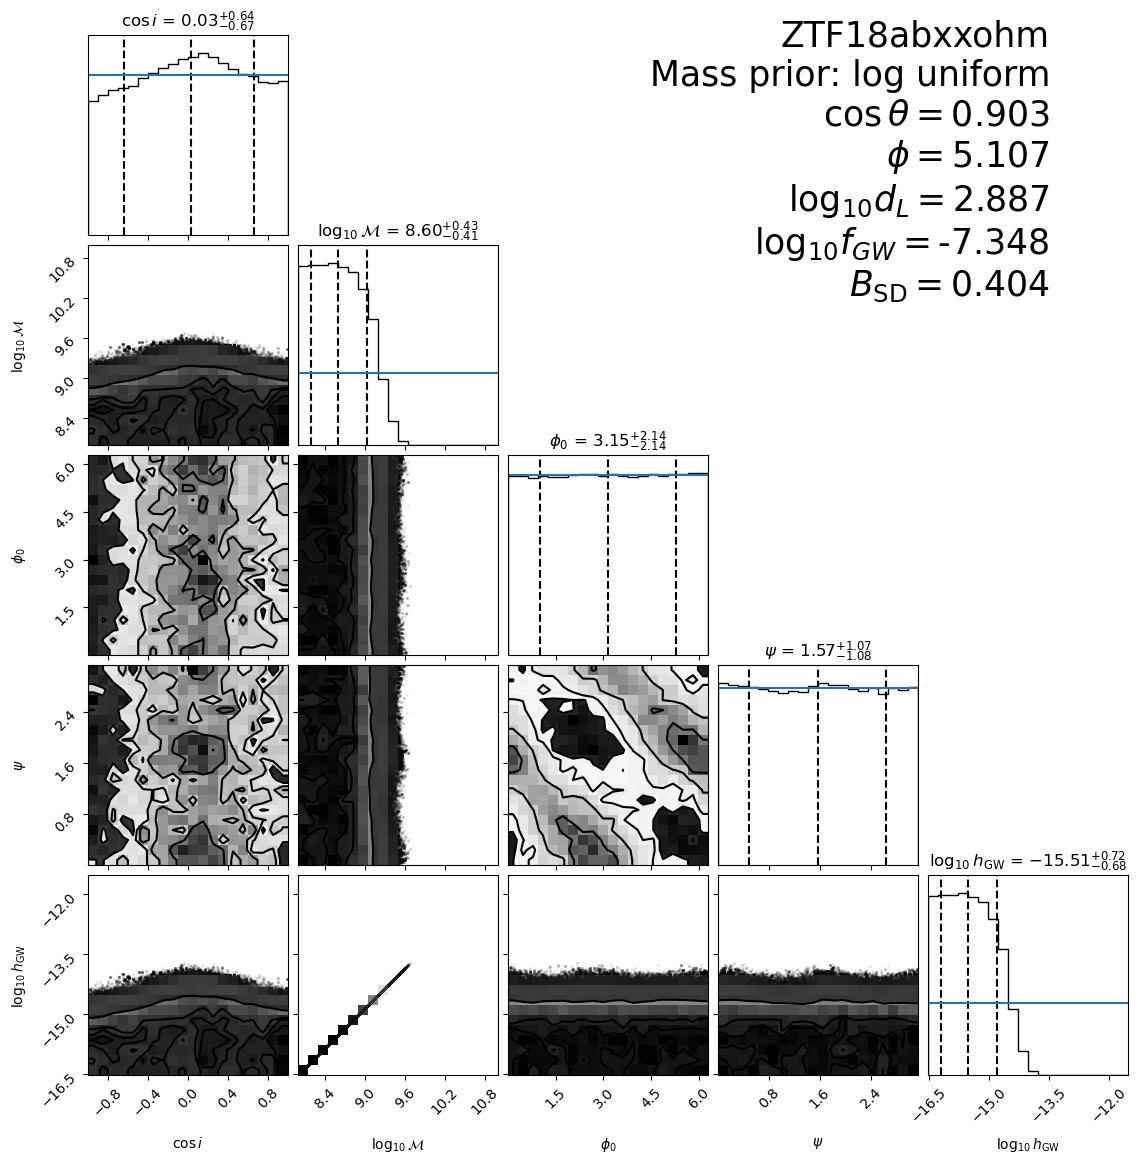

In [20]:
samples_to_plot = combined_chain_burn[:,-8:-4]
samples_to_plot = np.hstack([samples_to_plot, [[x] for x in log10_strain]])

labels = params[-8:-4] + ['log10_h']
labels = [r'$\cos i$' if x == 'cos_inc'
         else r'$\log_{10} \mathcal{M}$' if x == 'log10_mc'
         else r'$\phi_0$' if x == 'phase0'
         else r'$\psi$' if x == 'psi'
         else r'$\log_{10} h_{\text{GW}}$' if x == 'log10_h'
         else x
         for x in labels]

ranges = [(-1, 1), (8, 11), (0, 2*np.pi), (0, np.pi), (log10_strain_min, log10_strain_max)]
pheights = [1/(x[1]-x[0]) for x in ranges]

massx = np.linrange(8, 11, 100)

fig = corner.corner(samples_to_plot,
                    labels=labels,
                    show_titles=True, 
                    quantiles=[0.16, 0.5, 0.84],
                    hist_kwargs={'density':True},
                    range=ranges)
theta = 7
fig.suptitle('ZTF18abxxohm\n'
             'Mass prior: log uniform\n'
             r'$\cos\theta=$' f'{0.903}\n'
             r'$\phi=$' f'{5.107}\n'
             r'log$_{10} d_L=$' f'{2.887}\n'
             r'log$_{10} f_{GW}=$' f'{-7.348}\n'
             r'$B_{\text{SD}}=$' f'{bf_mass:.3f}\n',
             horizontalalignment='right', x=0.9, fontsize=25)

# Add priors

for i, ax in enumerate(fig.axes):
    if i==0: # cos i
        ax.axhline(pheights[0])
    if i==6: # log10 mc
        ax.axhline(pheights[1])
    if i==12: # phi0
        ax.axhline(pheights[2])
    if i==18: # psi
        ax.axhline(pheights[3])
    if i==24: #log10 strain
        ax.axhline(pheights[4])

In [22]:
fig.savefig('/vast/palmer/home.grace/frh7/palmer_scratch/ztfcorner.png')

In [73]:
priorpath = dataPath / '1' / 'priors.txt'
priorlist = np.loadtxt(priorpath, dtype='str', delimiter='\t')
priors = {}
for pline in priorlist:
    ind1 = pline.index(':')
    ind2 = pline.index('(')
    ind3 = pline.index(',')
    ind4 = pline.index(')')

    pname = pline[:ind1]
    ptype = pline[ind1+1:ind2]
    parg1 = pline[ind2+1:ind3]
    parg2 = pline[ind3+2:ind4]
    try:
        parg2.index(',')
        raise NotImplementedError('Prior with >2 params')
    except ValueError:
        pass
    priors[pname] = {'type': ptype, 'arg1': parg1, 'arg2': parg2}
priors

{'B1855+09_cw_p_dist': {'type': 'PXDist',
  'arg1': 'dist=1.1820330969267139',
  'arg2': 'err=0.1243509995584841'},
 'B1855+09_cw_p_phase': {'type': 'Uniform',
  'arg1': 'pmin=0',
  'arg2': 'pmax=6.283185307179586'},
 'B1855+09_red_noise_gamma': {'type': 'Uniform',
  'arg1': 'pmin=0',
  'arg2': 'pmax=7'},
 'B1855+09_red_noise_log10_A': {'type': 'Uniform',
  'arg1': 'pmin=-20',
  'arg2': 'pmax=-11'},
 'B1937+21_cw_p_dist': {'type': 'PXDist',
  'arg1': 'dist=3.095975232198142',
  'arg2': 'err=0.20128631540607117'}}

In [56]:
priors[0]

'B1855+09_cw_p_dist:PXDist(dist=1.1820330969267139, err=0.1243509995584841)'

In [58]:
ind1 = priors[0].index(':')

In [59]:
ind2 = priors[0].index('(')

In [60]:
ind3 = priors[0].index(',')

In [61]:
ind4 = priors[0].index(')')

In [63]:
priors[0][:ind1]

'B1855+09_cw_p_dist'

In [65]:
priors[0][ind1+1:ind2]

'PXDist'

In [66]:
priors[0][ind2+1:ind3]

'dist=1.1820330969267139'

In [67]:
priors[0][ind3+2:ind4]

'err=0.1243509995584841'